# Predictive accuracy of Regularization and PCR methods in high-dimensional panel data
#### by Muhammad Danial Syed, ID # 3435122

## Part 1: Simulation Study

### 1) Initialization 

In [2]:
#rm(list=ls())

suppressMessages(library(glmnet))
suppressMessages(library(mvtnorm))
suppressMessages(library(parallel))
suppressMessages(library(ggplot2))
suppressMessages(library(doMC))
suppressMessages(library(fbi))
suppressMessages(library(factoextra))
suppressMessages(library(pls))
suppressMessages(library(repr))
suppressMessages(library(lubridate))
suppressMessages(library(dplyr))
suppressMessages(library(coefplot))
suppressMessages(library(xtable))

numCores <- detectCores()
registerDoMC(cores = numCores)


### 2) Data Generating Process

In [3]:
data <- function(N, T, a, b) {

    lambda <- matrix(rnorm((N)*8), N, 8)
    v <- matrix(rnorm((T+1)*(N+2)), T+1, N+2)
    e <- matrix(0, T+1, N+2)
    f <- matrix(rnorm((T+1)*8), T+1, 8)
    
    for (t in 2:(T+1)) {
        for (i in 2:(N+1)) {
            e[t,i] <- a*e[t-1,i] + (1+b^2)*v[t,i] + b*v[t,i+1] + b*v[t,i-1]
        }
    }

    x <- f%*%t(lambda) + e[,2:(N+1)]
    Yepsilon <- rnorm(T)

    Y    <- matrix(NA, ncol = 1, nrow = T)
    iota <- matrix(1, ncol=8, nrow=1)
    
    for (t in 1:T) {
        Y[t] <- iota %*% f[t,] + Yepsilon[t]
    }
    
    X <- x[(2):nrow(x),]
    F <- f[(2):nrow(x),]
    
    return(list(X=X, Y=Y))  
}


### 3) Forecasting Function

In [4]:
sim_forecast <- function(mydata) {
    
    X_data <- cbind(mydata$Y[1:T], mydata$X[1:T,])
    Y_data <- as.matrix(mydata$Y[(1+forecast_horizon):T])

    num_pred      <- ((nrow(Y_data) - rolling_window)) 
    true_value    <- rep(NA, num_pred)
    pred_Lasso    <- rep(NA, num_pred)
    pred_PCR      <- rep(NA, num_pred)
    pred_ridge    <- rep(NA, num_pred)
    pred_pcL      <- rep(NA, num_pred)
    rmse_Lasso    <- rep(NA, num_pred)
    rmse_PCR      <- rep(NA, num_pred)
    rmse_ridge    <- rep(NA, num_pred)
    rmse_pcL      <- rep(NA, num_pred)

    ws  <- 0
    we  <- 0
    
    for (i in 1:num_pred){

        set.seed(70)
        ws <- i
        we <- ws + rolling_window - 1
            
        X_sample    <- X_data[ws:we,]
        X_sample_df <- as.data.frame(X_sample)
        Y_sample    <- as.matrix(Y_data[ws:we])

        X_test      <- matrix(X_data[(we + 1),], ncol = ncol(X_sample), nrow = 1)
        Y_test      <- as.matrix(Y_data[(we + 1)])
 
        train_Lasso <- cv.glmnet(X_sample, Y_sample, type.measure="mse", alpha=1, standardize=TRUE, nfolds=5)
        train_ridge <- cv.glmnet(X_sample, Y_sample, type.measure="mse", alpha=0, standardize=TRUE, nfolds=5)
        train_PCR   <- pcr(Y_sample~ ., data=X_sample_df, scale=TRUE)

        pred_Lasso[ws]    <- predict(train_Lasso, newx=X_test, s=train_Lasso$lambda.min)
        pred_ridge[ws]    <- predict(train_ridge, newx=X_test, s=train_ridge$lambda.min)
        pred_PCR[ws]      <- predict(train_PCR, X_test, ncomp=8)
        pred_pcL[ws]      <- 0.5*pred_Lasso[ws] + 0.5*pred_PCR[ws]
        true_value[ws]    <- Y_test
    }
            
    rmse_Lasso <- sqrt(mean((pred_Lasso - true_value)^2))
    rmse_PCR   <- sqrt(mean((pred_PCR - true_value)^2))
    rmse_ridge <- sqrt(mean((pred_ridge - true_value)^2))
    rmse_pcL   <- sqrt(mean((pred_pcL - true_value)^2))
    rmse       <- cbind(rmse_Lasso, rmse_PCR, rmse_ridge, rmse_pcL)
    
    predicted_values <- cbind(true_value, pred_Lasso, pred_PCR, pred_ridge, pred_pcL)
    
    emp_out <- list("rmse" = rmse, "predicted_values" = predicted_values)
    return(emp_out)
}


### 4) A Preview of the Simulation: Scree Plot and Time Plot of a Single Iteration

In [5]:
N <- 150
T <- 241
T_0 <- 120
forecast_horizon <- 1
rolling_window   <- T_0
a <- 0.5
b <- 0.5

set.seed(70)
mydata       <- data(N, T, a, b)
forecast_obj <- sim_forecast(mydata)

X_data  <- mydata$X
Y_data  <- matrix(mydata$Y, ncol=1, nrow=T)
dataset <- cbind(Y_data, X_data)
df      <- as.data.frame(dataset)

start_day = as.Date('1980-01-01', format = '%Y-%m-%d')
end_day = as.Date('2000-01-01', format = '%Y-%m-%d')

df_dates = as.data.frame(seq(from = start_day, to = end_day, by = 'month'))
colnames(df_dates) = 'date'
df$date         <- ymd(df_dates$date)

time_series <- df[(rolling_window+1):(T-1),c(152, 1)]
colnames(time_series) <- c('date', 'actual')
time_series$lasso_pred    <- forecast_obj$predicted_values[,2]
time_series$pcr_pred      <- forecast_obj$predicted_values[,3]
time_series$ridge_pred    <- forecast_obj$predicted_values[,4]
time_series$pcL           <- forecast_obj$predicted_values[,5]

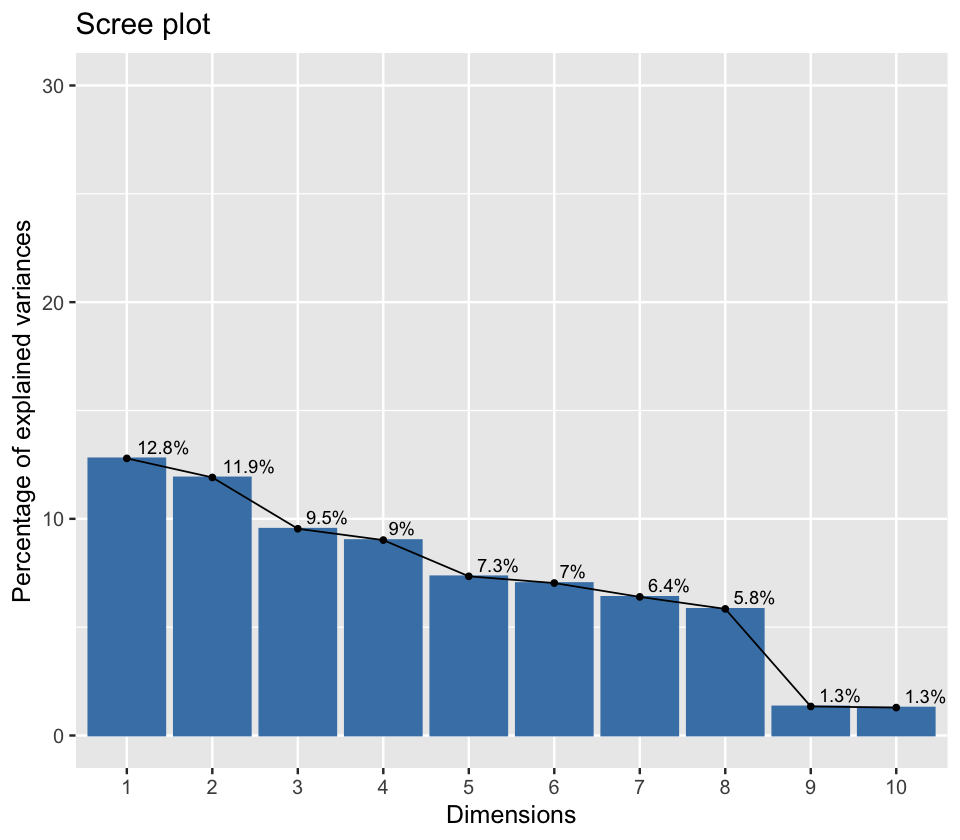

In [7]:
# Scree Plot
pc        <- prcomp(X_data, scale = TRUE)
fviz_eig(pc, addlabels=TRUE, hjust = -0.2) + ylim(0, 30) +
theme_grey(base_size = 15) 
options(repr.plot.width=8, repr.plot.height=7)

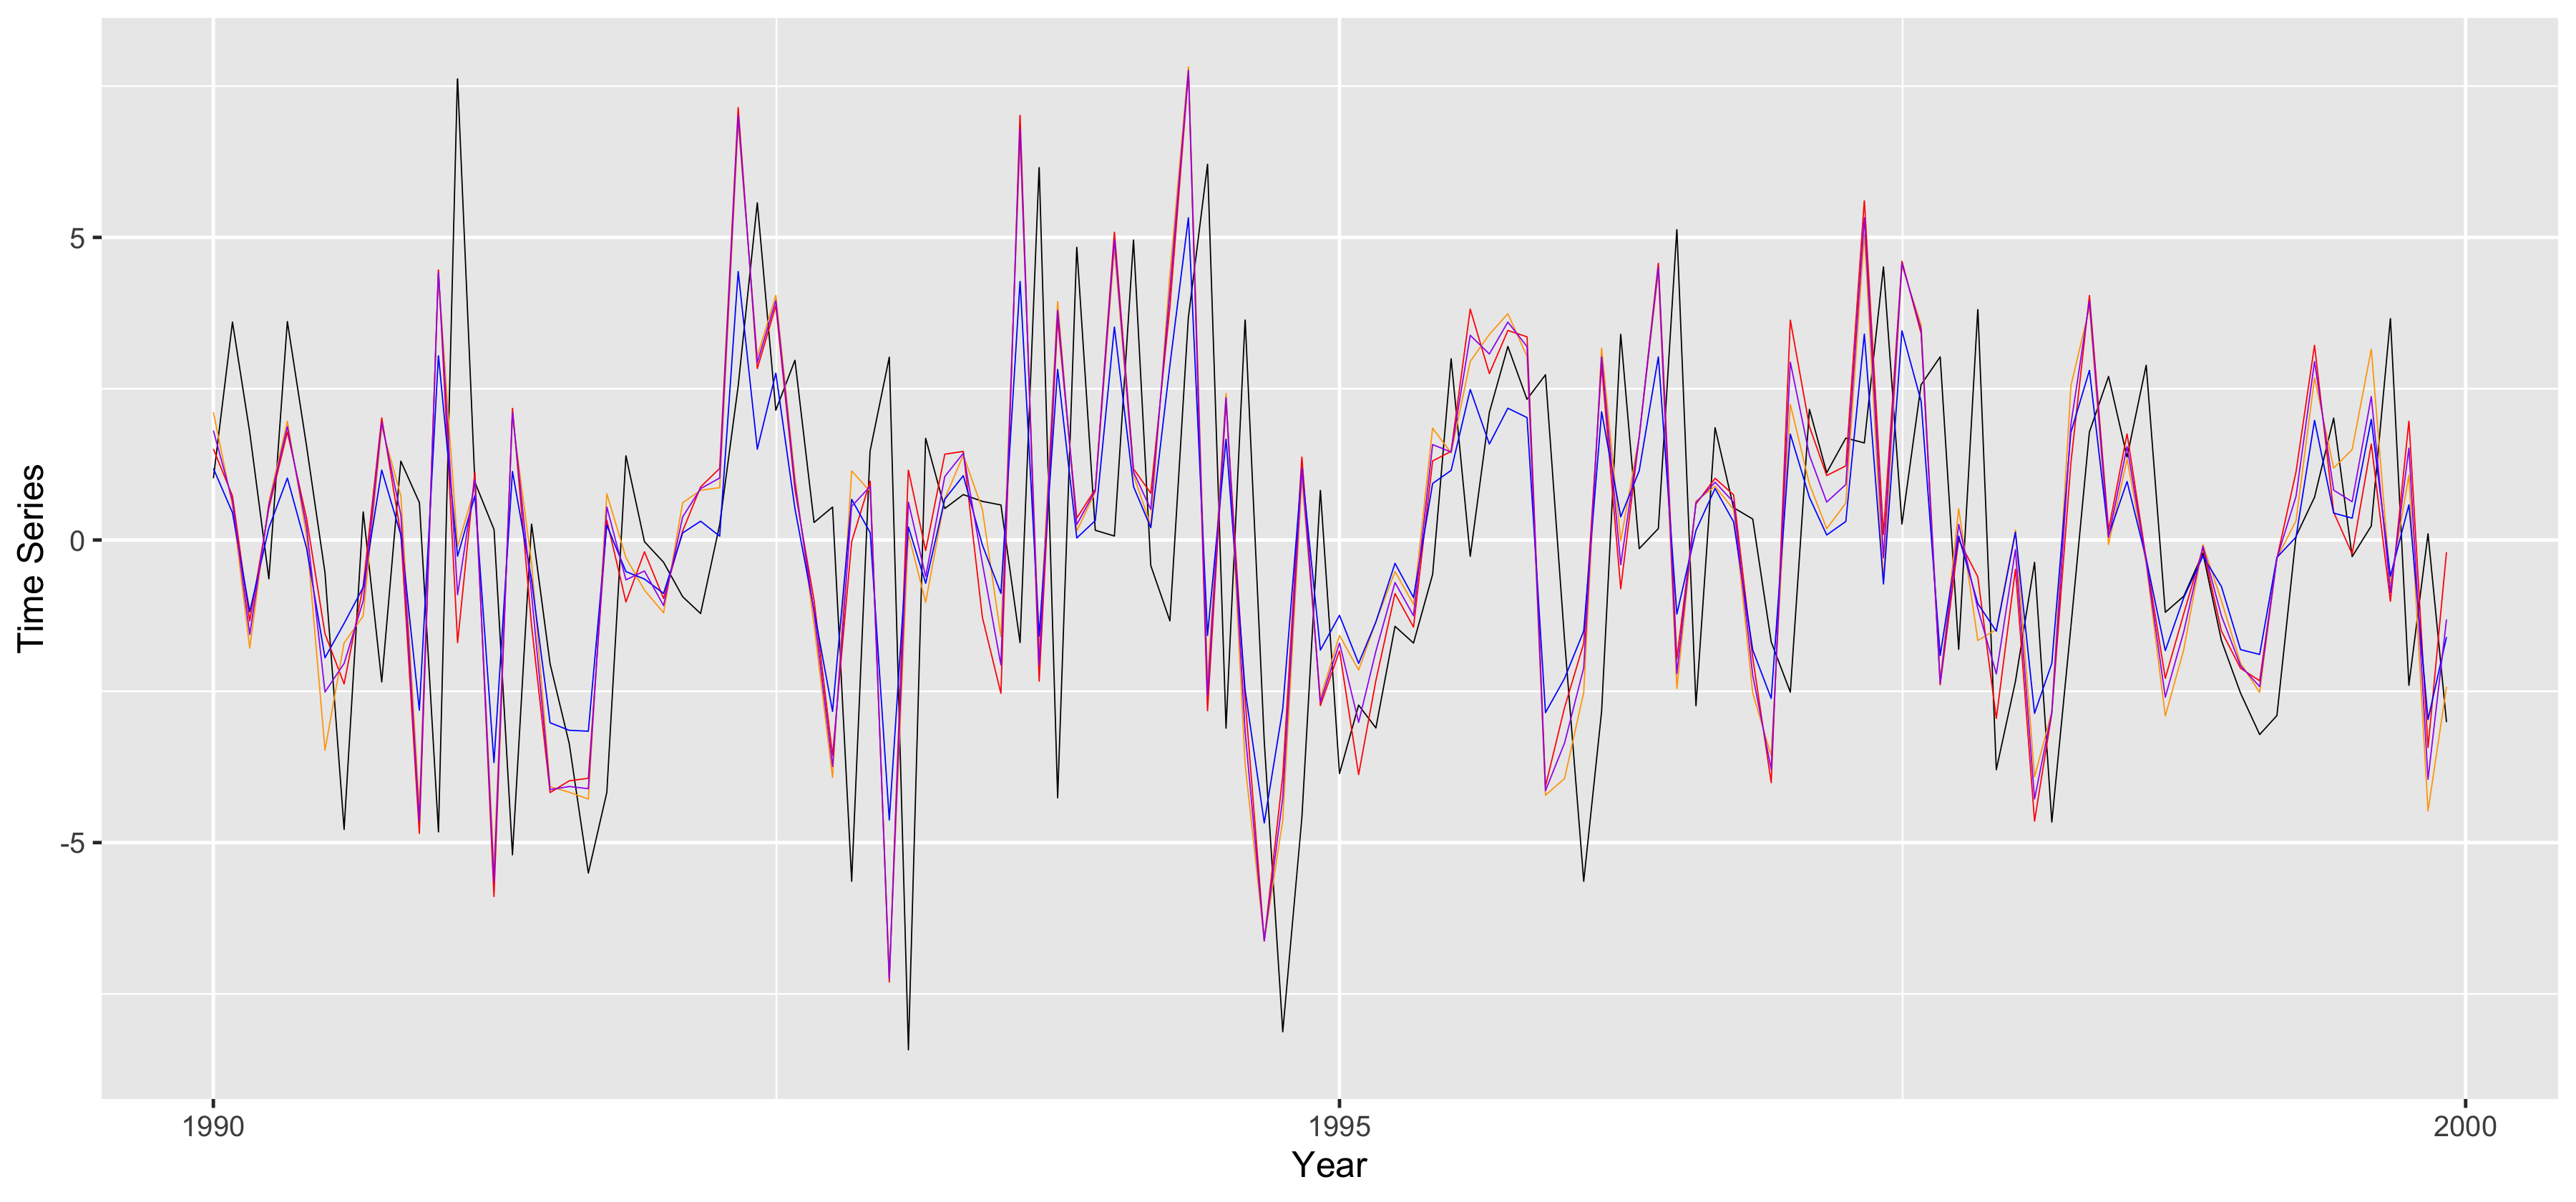

In [9]:
# Time Series Plot
ggplot() + 
  geom_line(data = time_series, aes(x = date, y = actual), color = "black") +
  geom_line(data = time_series, aes(x = date, y = lasso_pred), color = "red") +
  geom_line(data = time_series, aes(x = date, y = pcr_pred), color = "orange") +
  geom_line(data = time_series, aes(x = date, y = ridge_pred), color = "blue") +
  geom_line(data = time_series, aes(x = date, y = pcL), color = "purple") +
  theme_grey(base_size = 30) + 
  xlab('Year') +
  ylab('Time Series') 
  #coord_cartesian(ylim=c(-5, 10)) 
options(repr.plot.width=30, repr.plot.height=14)

### 5) Parameter Setup

In [10]:
### Fixed Design Parameters
N <- 150
T <- 241
T_0 <- 120
forecast_horizon <- 1
rolling_window   <- T_0

## Varying the autocorrelation from 0 to 0.9
a    <- seq(0, 0.9, by = 0.05)
sim  <- length(a)

# Number of iterations to perform over each autocorrelation coefficient 
rep = 100
mean.rmse_matrix_1 <- matrix(NA, ncol = 4, nrow = sim)
mean.rmse_matrix_2 <- matrix(NA, ncol = 4, nrow = sim)

### 6a) Case #1 - Simulation with cross-series correlation b = 0.5


In [11]:
b <- 0.5

set.seed(70)
RNGkind("L'Ecuyer-CMRG")

for (j in 1:sim) {
    
    boot_fx <- function(iteration) {
        mydata <- data(N, T, a[j], b)
        output.matrix <- sim_forecast(mydata)$rmse
        return(output.matrix) 
    }

    combined_matrix <- mclapply(1:rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    rmse_matrix     <- do.call(rbind, combined_matrix)
    
    mean.rmse_matrix_1[j,1]  <- mean(rmse_matrix[,1])
    mean.rmse_matrix_1[j,2]  <- mean(rmse_matrix[,2])
    mean.rmse_matrix_1[j,3]  <- mean(rmse_matrix[,3])
    mean.rmse_matrix_1[j,4]  <- mean(rmse_matrix[,4])
}

### 6b) Case #2 - Simulation with cross-series correlation b = 0.9

In [12]:
b <- 0.9

set.seed(70)
RNGkind("L'Ecuyer-CMRG")

for (j in 1:sim) {
    
    boot_fx <- function(iteration) {
        mydata <- data(N, T, a[j], b)
        output.matrix <- sim_forecast(mydata)$rmse
        return(output.matrix) 
    }

    combined_matrix <- mclapply(1:rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    rmse_matrix     <- do.call(rbind, combined_matrix)
    
    mean.rmse_matrix_2[j,1]  <- mean(rmse_matrix[,1])
    mean.rmse_matrix_2[j,2]  <- mean(rmse_matrix[,2])
    mean.rmse_matrix_2[j,3]  <- mean(rmse_matrix[,3])
    mean.rmse_matrix_2[j,4]  <- mean(rmse_matrix[,4])
}

### 7) Showing the Results

In [13]:
s   <- seq(1,19, by = 2)
rho <- as.data.frame(a[s])
results_df <- as.data.frame(cbind(mean.rmse_matrix_1[c(s),], mean.rmse_matrix_2[c(s),]))
results_df <- cbind(rho, results_df)
colnames(results_df)[1:9] <- c("p", "LASSO", "PCR", "Ridge", "Combined", "LASSO", "PCR", "Ridge", "Combined")

In [17]:
results_df <- round(results_df, 2)
xtable(results_df)

p   LASSO PCR  Ridge Combined LASSO PCR  Ridge Combined
1  0.0 1.39  1.21 1.54  1.26     1.51  1.33 1.65  1.34    
2  0.1 1.37  1.20 1.54  1.25     1.48  1.33 1.65  1.33    
3  0.2 1.35  1.20 1.54  1.23     1.47  1.33 1.65  1.32    
4  0.3 1.36  1.21 1.55  1.24     1.45  1.34 1.66  1.31    
5  0.4 1.35  1.22 1.55  1.24     1.45  1.36 1.66  1.33    
6  0.5 1.33  1.23 1.56  1.23     1.45  1.41 1.68  1.33    
7  0.6 1.33  1.26 1.57  1.24     1.43  1.49 1.70  1.36    
8  0.7 1.34  1.32 1.59  1.27     1.43  1.66 1.73  1.42    
9  0.8 1.35  1.50 1.62  1.33     1.44  2.06 1.78  1.53    
10 0.9 1.36  2.01 1.68  1.48     1.49  2.44 1.89  1.71

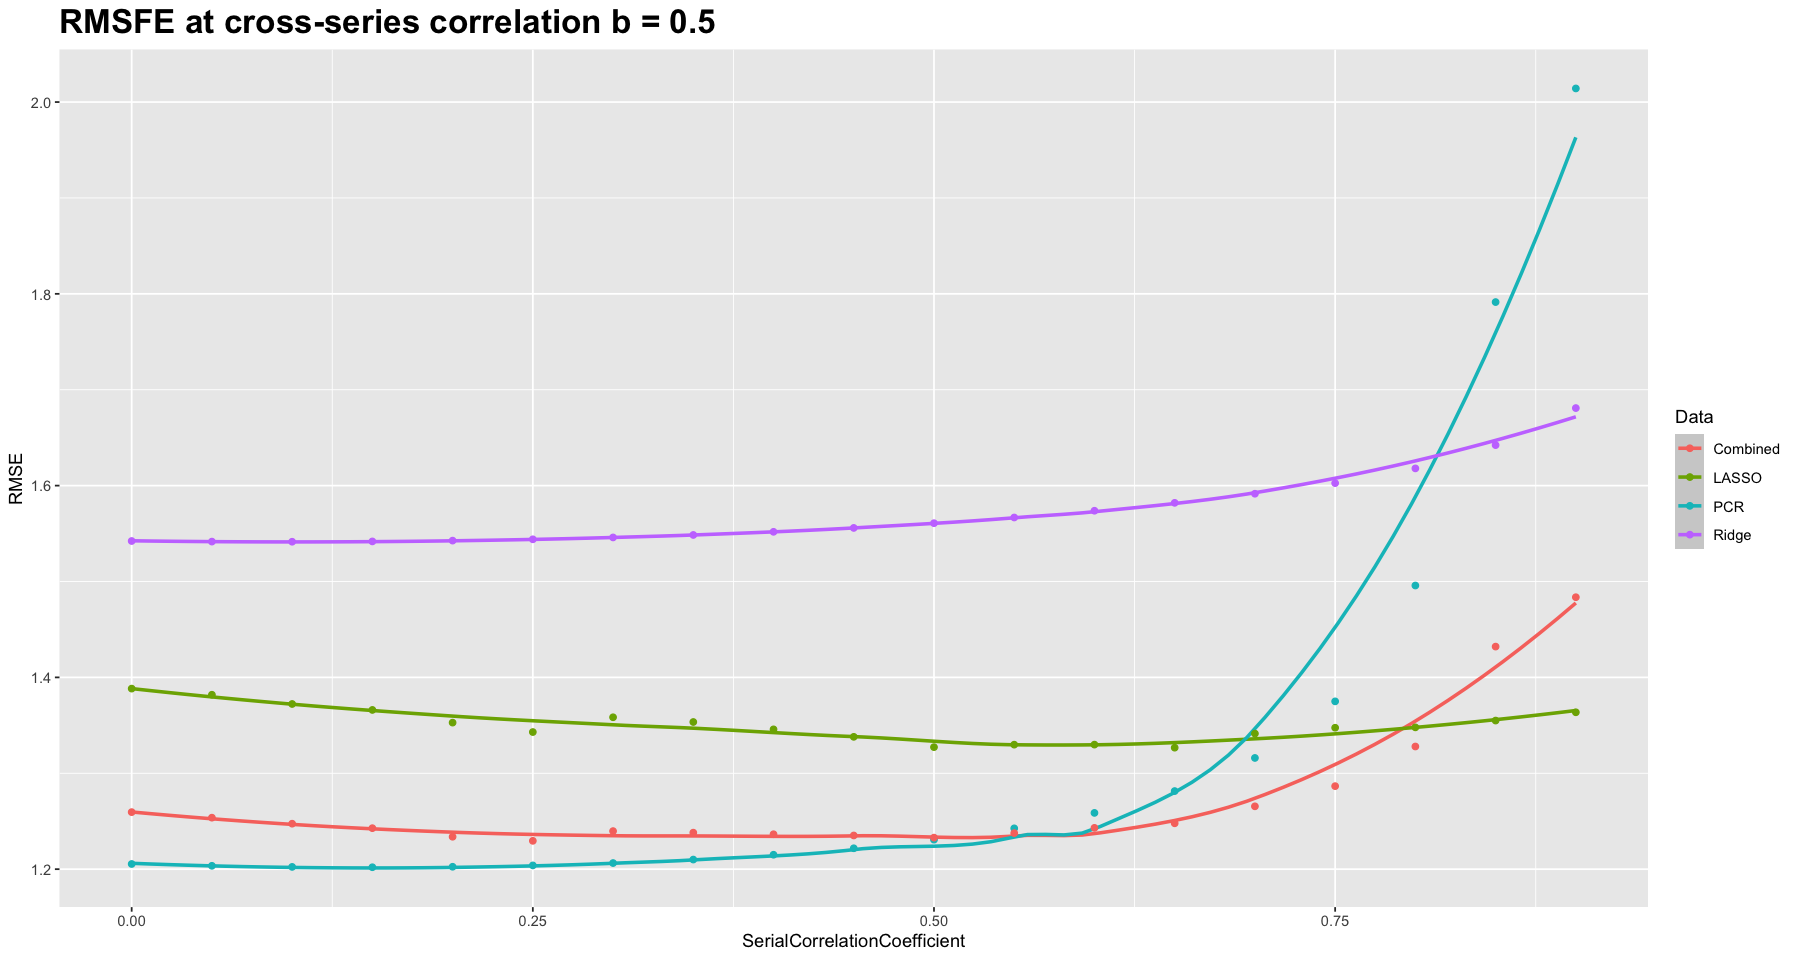

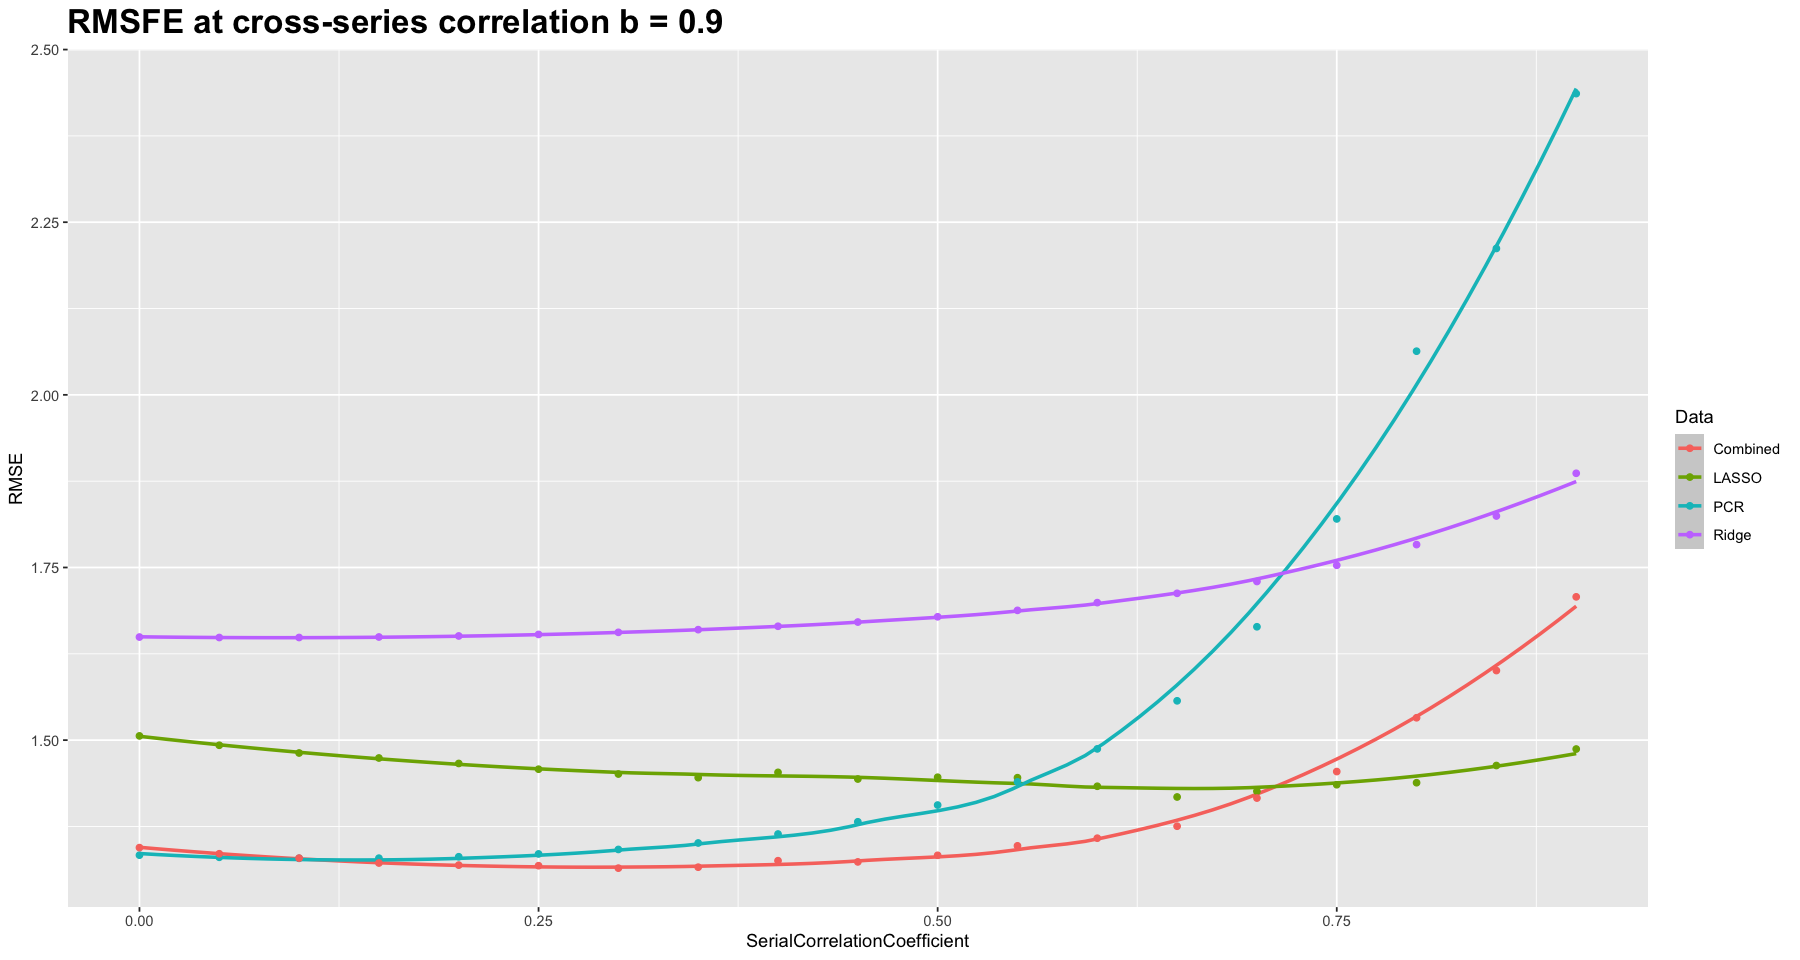

In [16]:
# RMSE matrix for each case
rmse_case1 <- mean.rmse_matrix_1
rmse_case2 <- mean.rmse_matrix_2

# Organization of RMSE matrices for plotting
df1_rmse <- data.frame(c(rep("LASSO",sim), rep("PCR",sim), rep("Ridge",sim), rep("Combined",sim)),
    c(rmse_case1[,1],rmse_case1[,2], rmse_case1[,3], rmse_case1[,4]),         
    rep(a,4))
colnames(df1_rmse)<-c("Data","RMSE","SerialCorrelationCoefficient")

df2_rmse <- data.frame(c(rep("LASSO",sim), rep("PCR",sim), rep("Ridge",sim), rep("Combined",sim)),
    c(rmse_case2[,1],rmse_case2[,2], rmse_case2[,3], rmse_case2[,4]),         
    rep(a,4))
colnames(df2_rmse)<-c("Data","RMSE","SerialCorrelationCoefficient")

# Plot the RMSFE at different levels of serial correlation when b = 0.5
ggplot(data=df1_rmse, aes(x=SerialCorrelationCoefficient, y=RMSE, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("RMSFE at cross-series correlation b = 0.5") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the RMSE at different levels of serial correlation when b = 0.9
ggplot(data=df2_rmse, aes(x=SerialCorrelationCoefficient, y=RMSE, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("RMSFE at cross-series correlation b = 0.9") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)


## Part 2: Empirical Application: Forecasting U.S. ISM Manufacturing: Production Index, Production Price Index: Finished Goods, Oil Price Index, and the Consumer Price Index.

### 1) Initialization 

In [23]:
macro_data  <- fredmd(file = "https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv",
                    date_start = as.Date("1980-01-01"), date_end = as.Date("2019-12-01"), transform = TRUE)

rownames(macro_data) <- 1:nrow(macro_data)
dataset      <- subset(macro_data, select = c(-X58))                       
dataset$date <- ymd(dataset$date)
X_data       <- data.matrix(dataset[1:nrow(dataset),c(-1)])               
Y_t          <- cbind(dataset$X19, dataset$X106, dataset$X110, dataset$X113) 
Y_data       <- data.matrix(Y_t[(2):nrow(X_data),])     
#adf.test(Y_data[,1])

### 2) Scree Plot: First 8 PCs explain more than 95% variance

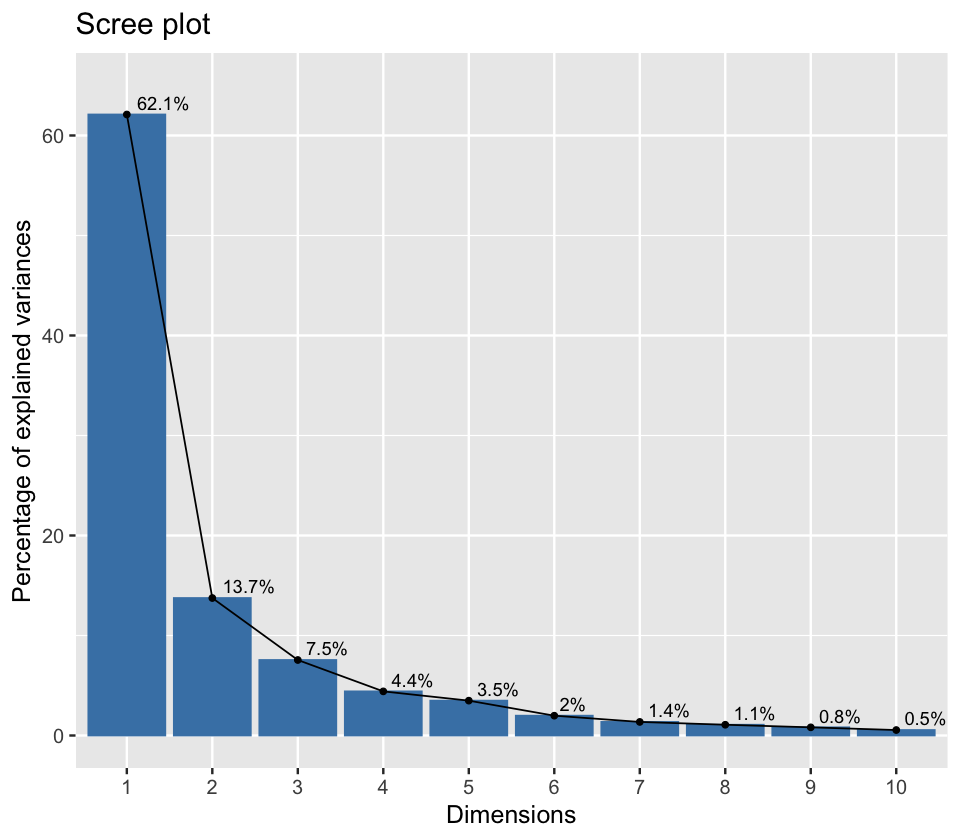

In [20]:
# Must reset transform in fredmd() to FALSE to see this
pc        <- prcomp(X_data, scale = TRUE)
fviz_eig(pc, addlabels=TRUE, hjust = -0.2) + ylim(0, 65) +
theme_grey(base_size = 15) 
options(repr.plot.width=8, repr.plot.height=7)

### 3) Forecast Function using rolling window

In [24]:
forecast <- function(forecast_horizon) {
    
    num_pred    <- nrow(Y_data) - rolling_window
    true_value  <- rep(NA, num_pred)
    pred_Lasso  <- rep(NA, num_pred)
    pred_PCR    <- rep(NA, num_pred)
    pred_ridge  <- rep(NA, num_pred)
    pred_pcL    <- rep(NA, num_pred)
    pred_AR     <- rep(NA, num_pred)
    rmse_Lasso  <- rep(NA, num_pred)
    rmse_PCR    <- rep(NA, num_pred)
    rmse_ridge  <- rep(NA, num_pred)
    rmse_pcL    <- rep(NA, num_pred)
    rmse_AR     <- rep(NA, num_pred)
    ws  <- 0
    we  <- 0
    
    for (j in 1:4){ 
        for (i in 1:num_pred){

            ws <- i
            we <- ws + rolling_window - 1
            
            X_sample    <- X_data[ws:we,]
            X_sample_df <- as.data.frame(X_sample)
            Y_sample    <- as.matrix(Y_data[ws:we, j])

            X_test      <- matrix(X_data[(we + 1),], ncol = ncol(X_sample), nrow = 1)
            Y_test      <- as.matrix(Y_data[(we + 1), j])
            
            set.seed(70)
            train_Lasso   <- cv.glmnet(X_sample, Y_sample, type.measure="mse", alpha=1, standardize=TRUE, nfolds=5)
            train_ridge   <- cv.glmnet(X_sample, Y_sample, type.measure="mse", alpha=0, standardize=TRUE, nfolds=5)
            train_PCR     <- pcr(Y_sample~ ., data=X_sample_df, scale=TRUE)
            train_AR      <- arima(Y_sample , order = c(1, 0, 0))
      
            pred_Lasso[ws]    <- predict(train_Lasso, newx=X_test, s=train_Lasso$lambda.min)
            pred_ridge[ws]    <- predict(train_ridge, newx=X_test, s=train_ridge$lambda.min)
            pred_PCR[ws]      <- predict(train_PCR, X_test, ncomp=8)
            pred_pcL[ws]      <- 0.5*pred_Lasso[ws] + 0.5*pred_PCR[ws]
            pred_AR[ws]       <- predict(train_AR, n.ahead = forecast_horizon)$pred[forecast_horizon]
            true_value[ws]    <- Y_test
            
        }
        
        rmse_Lasso   <- sqrt(mean((pred_Lasso - true_value)^2))
        rmse_PCR     <- sqrt(mean((pred_PCR - true_value)^2))
        rmse_ridge   <- sqrt(mean((pred_ridge - true_value)^2))
        rmse_pcL     <- sqrt(mean((pred_pcL - true_value)^2))
        rmse_AR      <- sqrt(mean((pred_AR - true_value)^2))
        
        if (j==1) {
            predicted_values_ISM <- cbind(true_value, pred_Lasso, pred_PCR, pred_ridge, pred_pcL, pred_AR)
            rmse_ISM             <- cbind(rmse_Lasso, rmse_PCR, rmse_ridge, rmse_pcL, rmse_AR)
        }
    
        if (j==2) {
            predicted_values_PPI <- cbind(true_value, pred_Lasso, pred_PCR, pred_ridge, pred_pcL, pred_AR)
            rmse_PPI             <- cbind(rmse_Lasso, rmse_PCR, rmse_ridge, rmse_pcL, rmse_AR)
        }
        
        if (j==3) {
            predicted_values_OIL <- cbind(true_value, pred_Lasso, pred_PCR, pred_ridge, pred_pcL, pred_AR)
            rmse_OIL             <- cbind(rmse_Lasso, rmse_PCR, rmse_ridge, rmse_pcL, rmse_AR)
        }
        
        if (j==4) {
            predicted_values_CPI <- cbind(true_value, pred_Lasso, pred_PCR, pred_ridge, pred_pcL, pred_AR)
            rmse_CPI             <- cbind(rmse_Lasso, rmse_PCR, rmse_ridge, rmse_pcL, rmse_AR)
        }
    
    }
       
emp_out <- list("predicted_values_ISM" = predicted_values_ISM, "predicted_values_PPI" = predicted_values_PPI, 
                "predicted_values_OIL" = predicted_values_OIL, "predicted_values_CPI" = predicted_values_CPI, 
                "rmse_ISM" = rmse_ISM, "rmse_PPI" = rmse_PPI, "rmse_OIL" = rmse_OIL, "rmse_CPI" = rmse_CPI)

}  

### 4) Results of one-period ahead forecast

In [26]:
rolling_window = 120
forecast_obj <- forecast(1)

emp_results <- as.data.frame(rbind(forecast_obj$rmse_ISM/forecast_obj$rmse_ISM[5],
                                  forecast_obj$rmse_PPI/forecast_obj$rmse_PPI[5], 
                                  forecast_obj$rmse_OIL/forecast_obj$rmse_OIL[5], 
                                  forecast_obj$rmse_CPI/forecast_obj$rmse_CPI[5]))

emp_results <- emp_results[,1:4]
rownames(emp_results)[1:4]  <- c("ISM Manufacturing: Production Index", 
                                 "PPI: Finished Goods", "Oil Price Index", "Consumer Price Index")

colnames(emp_results)[1:4]  <- c("LASSO", "PCR", "RIDGE", "Combined")
emp_results <- round(emp_results, 3)
emp_results

LASSO PCR   RIDGE Combined
ISM Manufacturing: Production Index 0.953 0.939 0.927 0.928   
PPI: Finished Goods                 0.929 1.043 0.982 0.948   
Oil Price Index                     0.926 1.037 0.967 0.948   
Consumer Price Index                0.930 1.046 0.989 0.953

### 5) Plotting the results

In [ ]:
library(xtable)
emp_results <- round(emp_results, 3)
#print(xtable(emp_results, auto = TRUE))

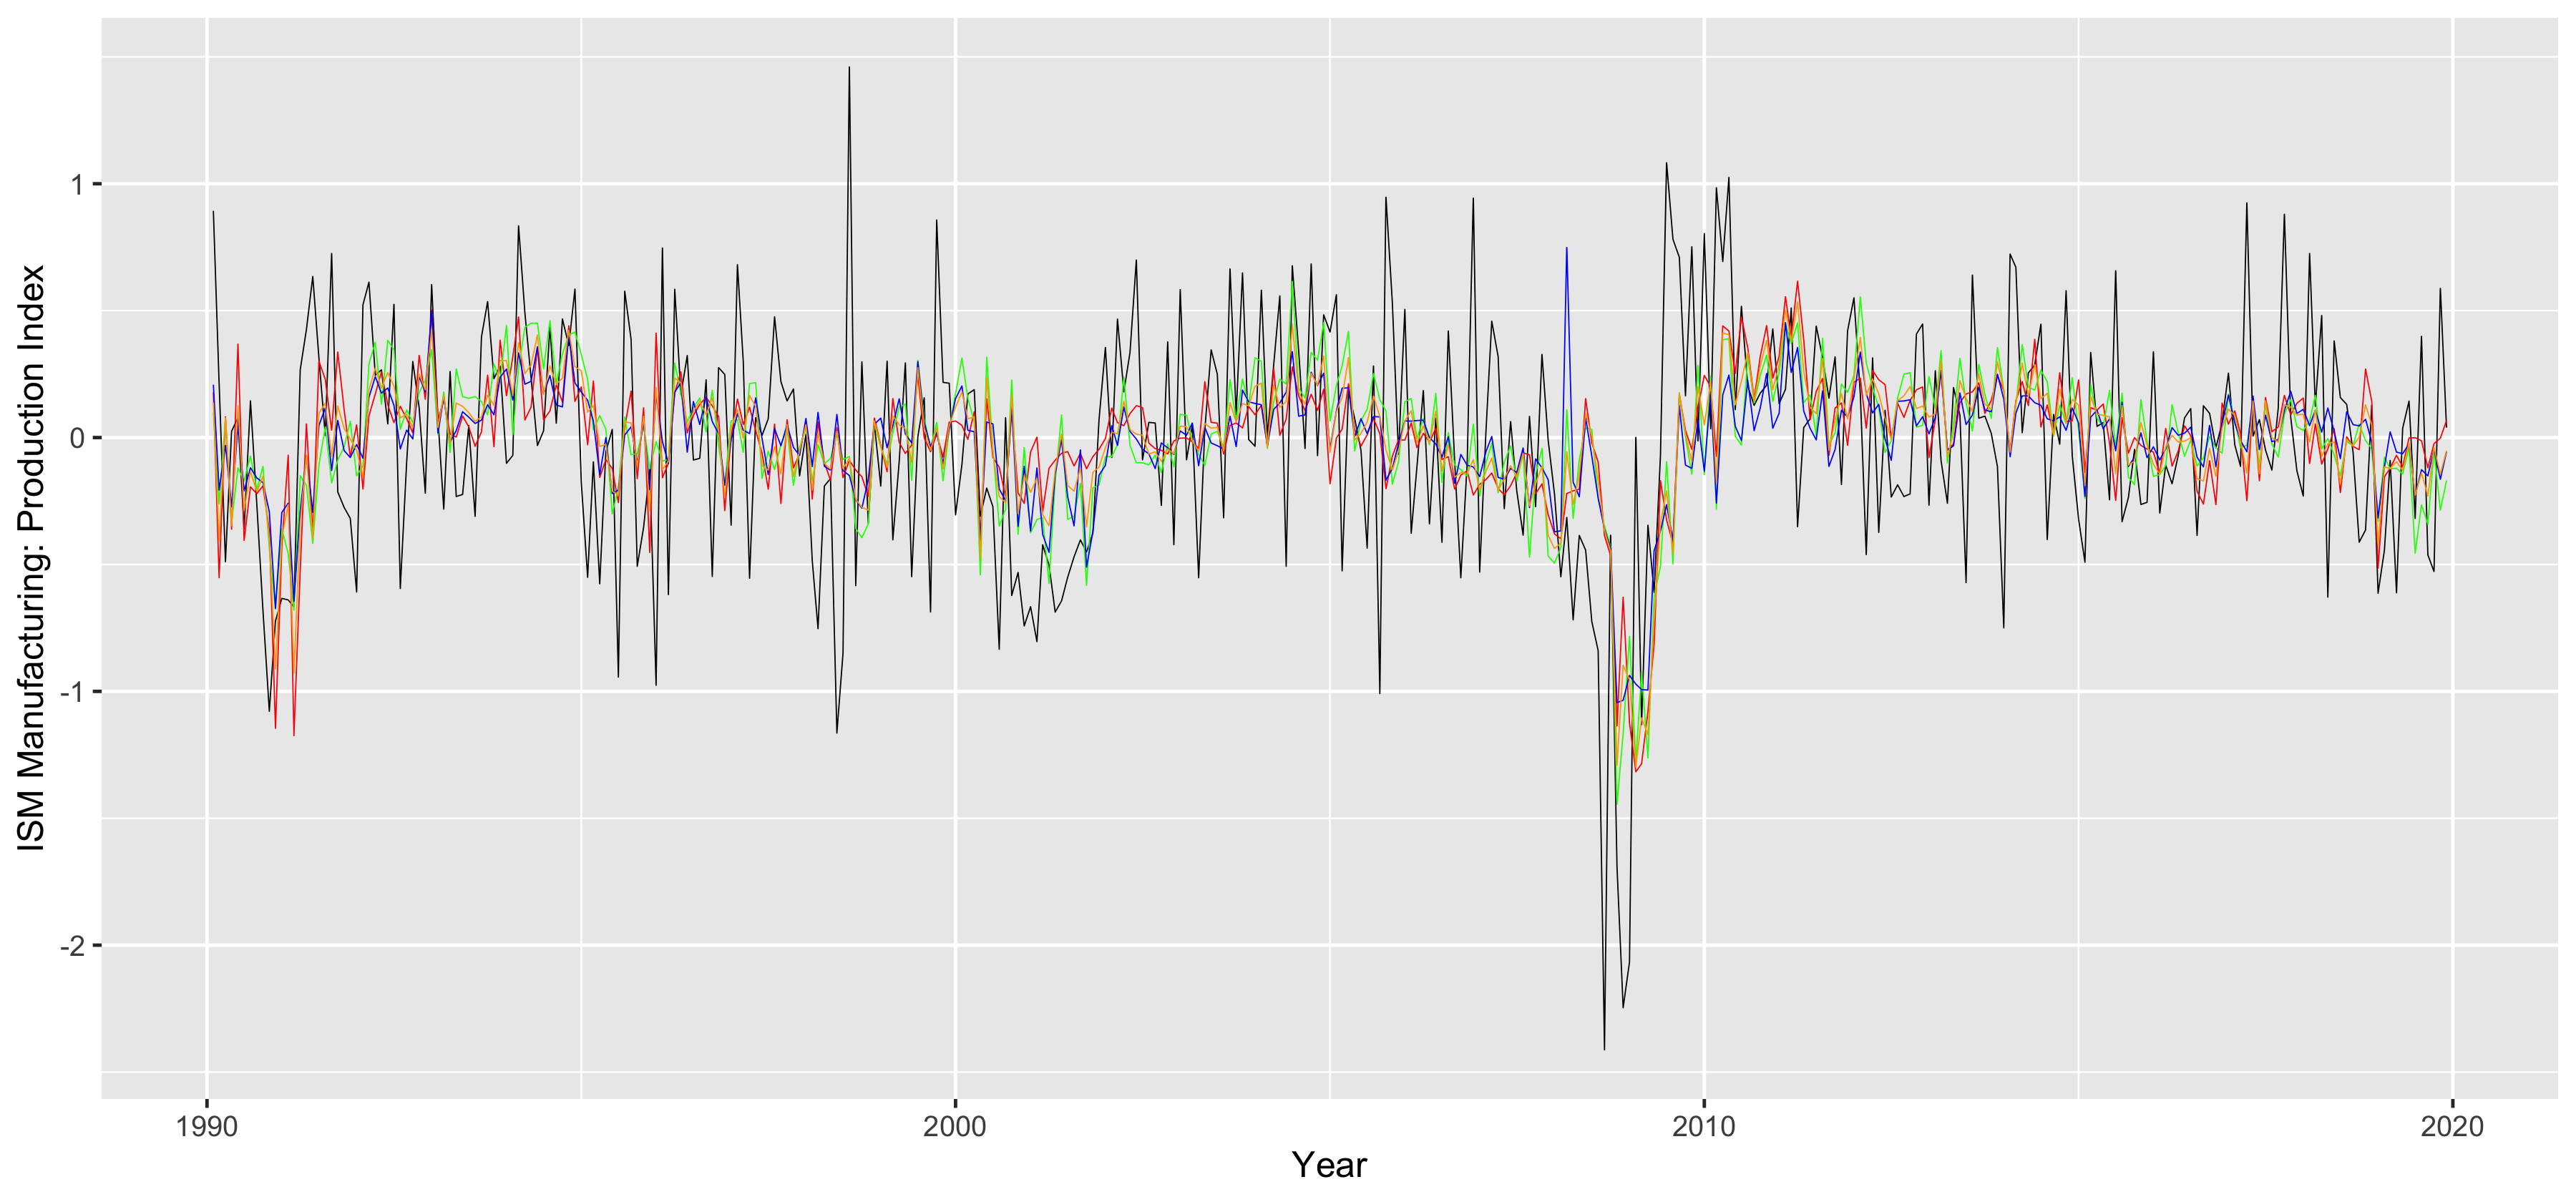

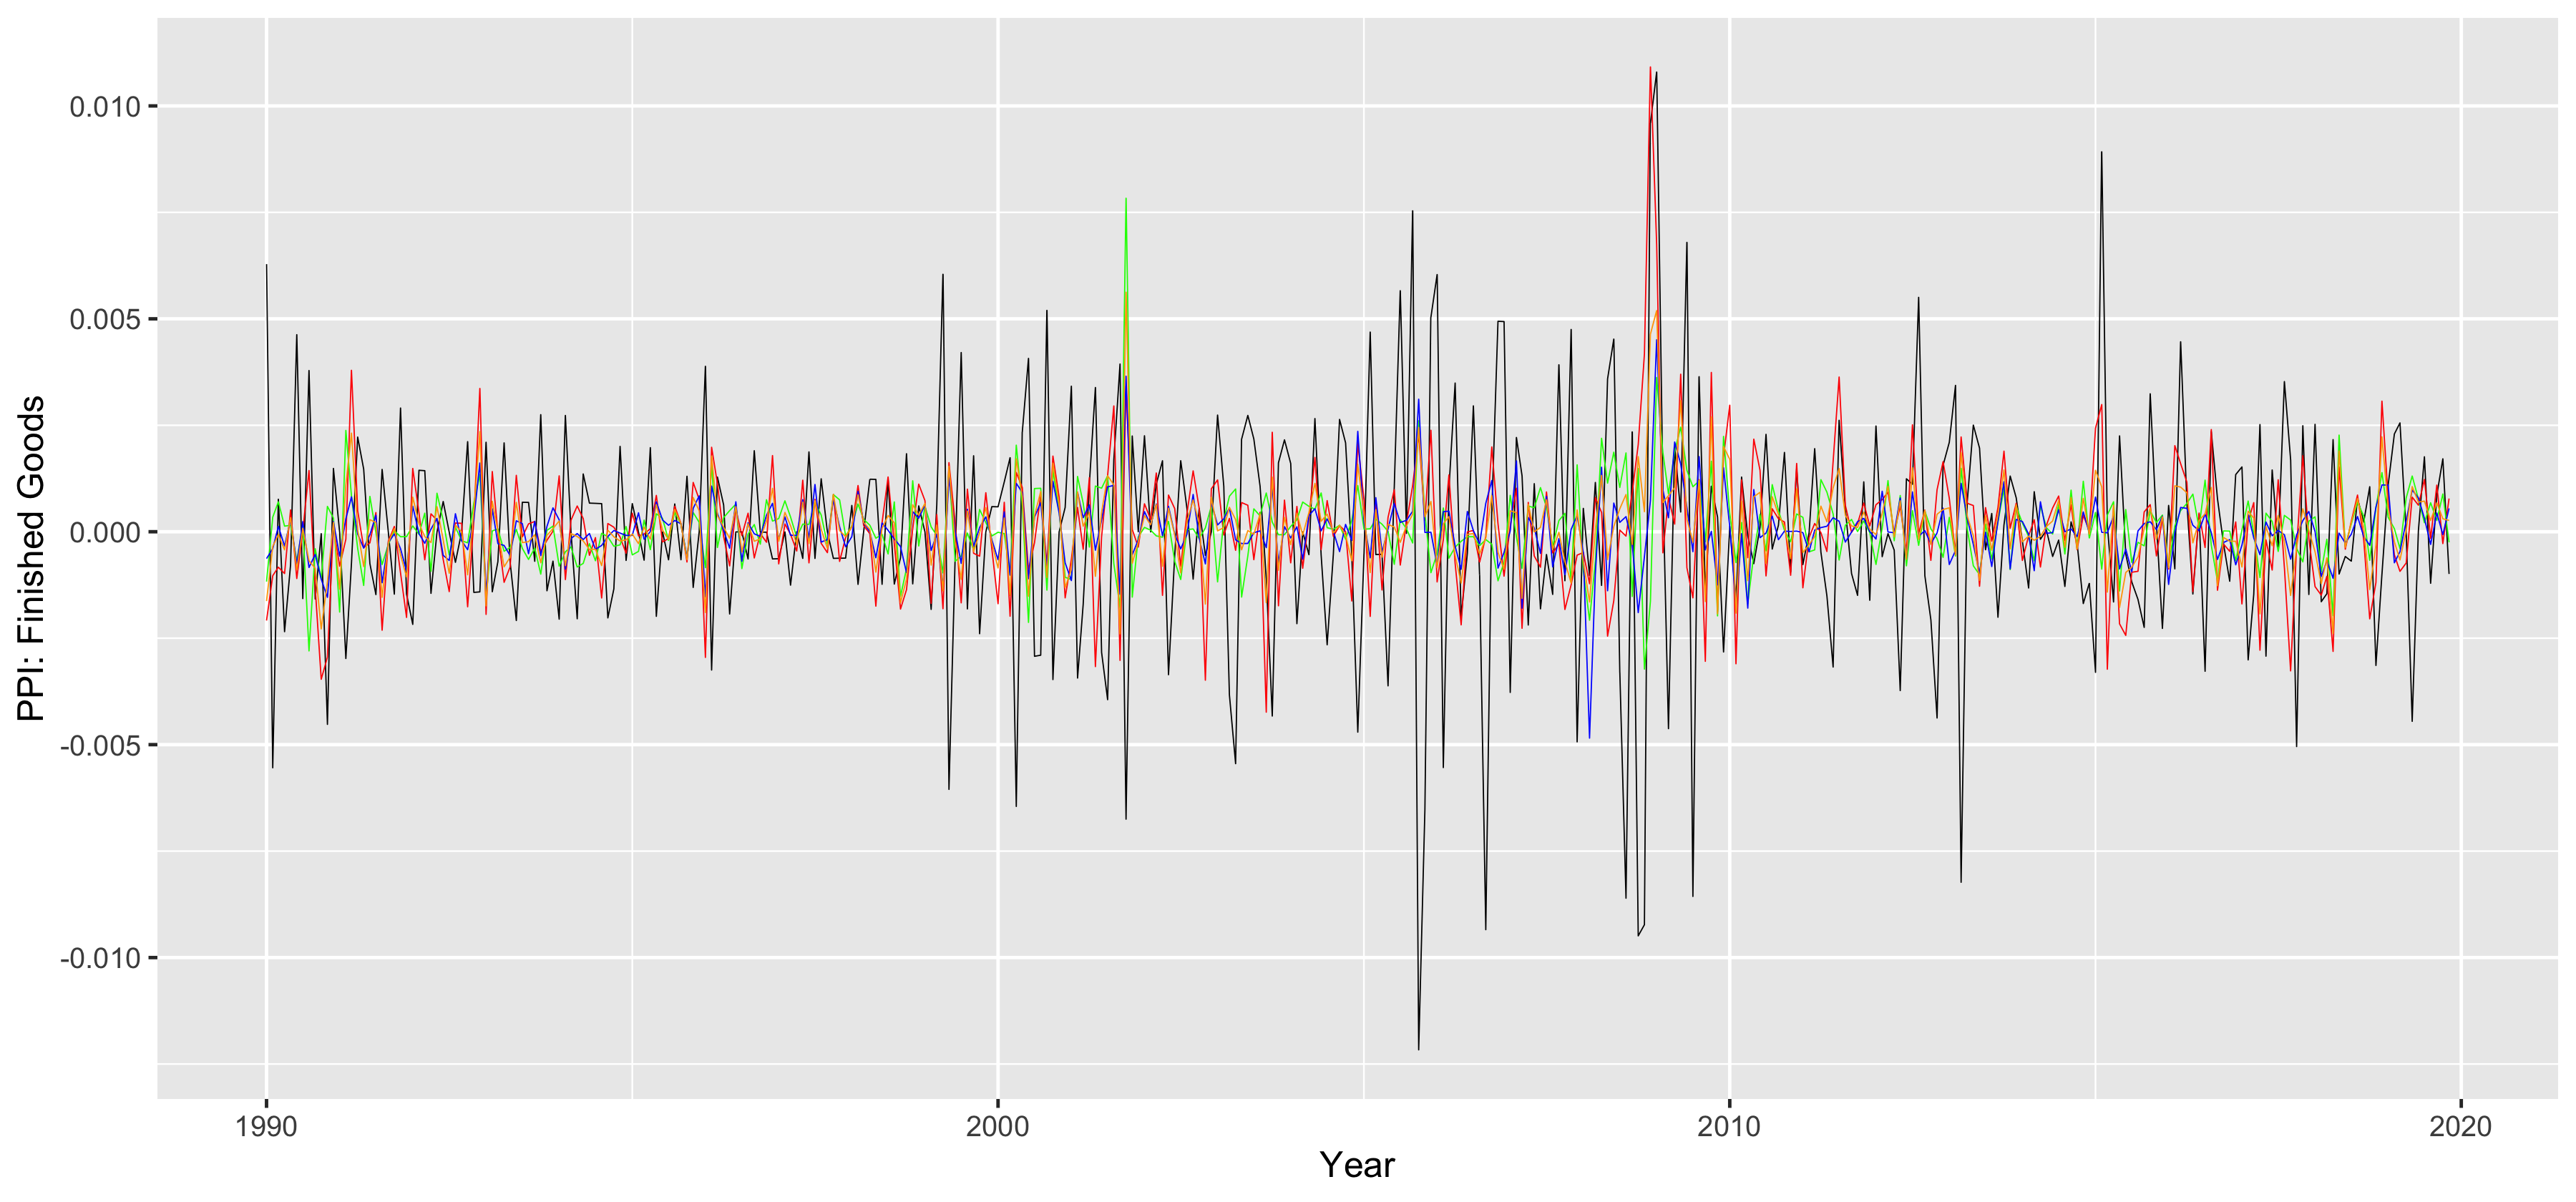

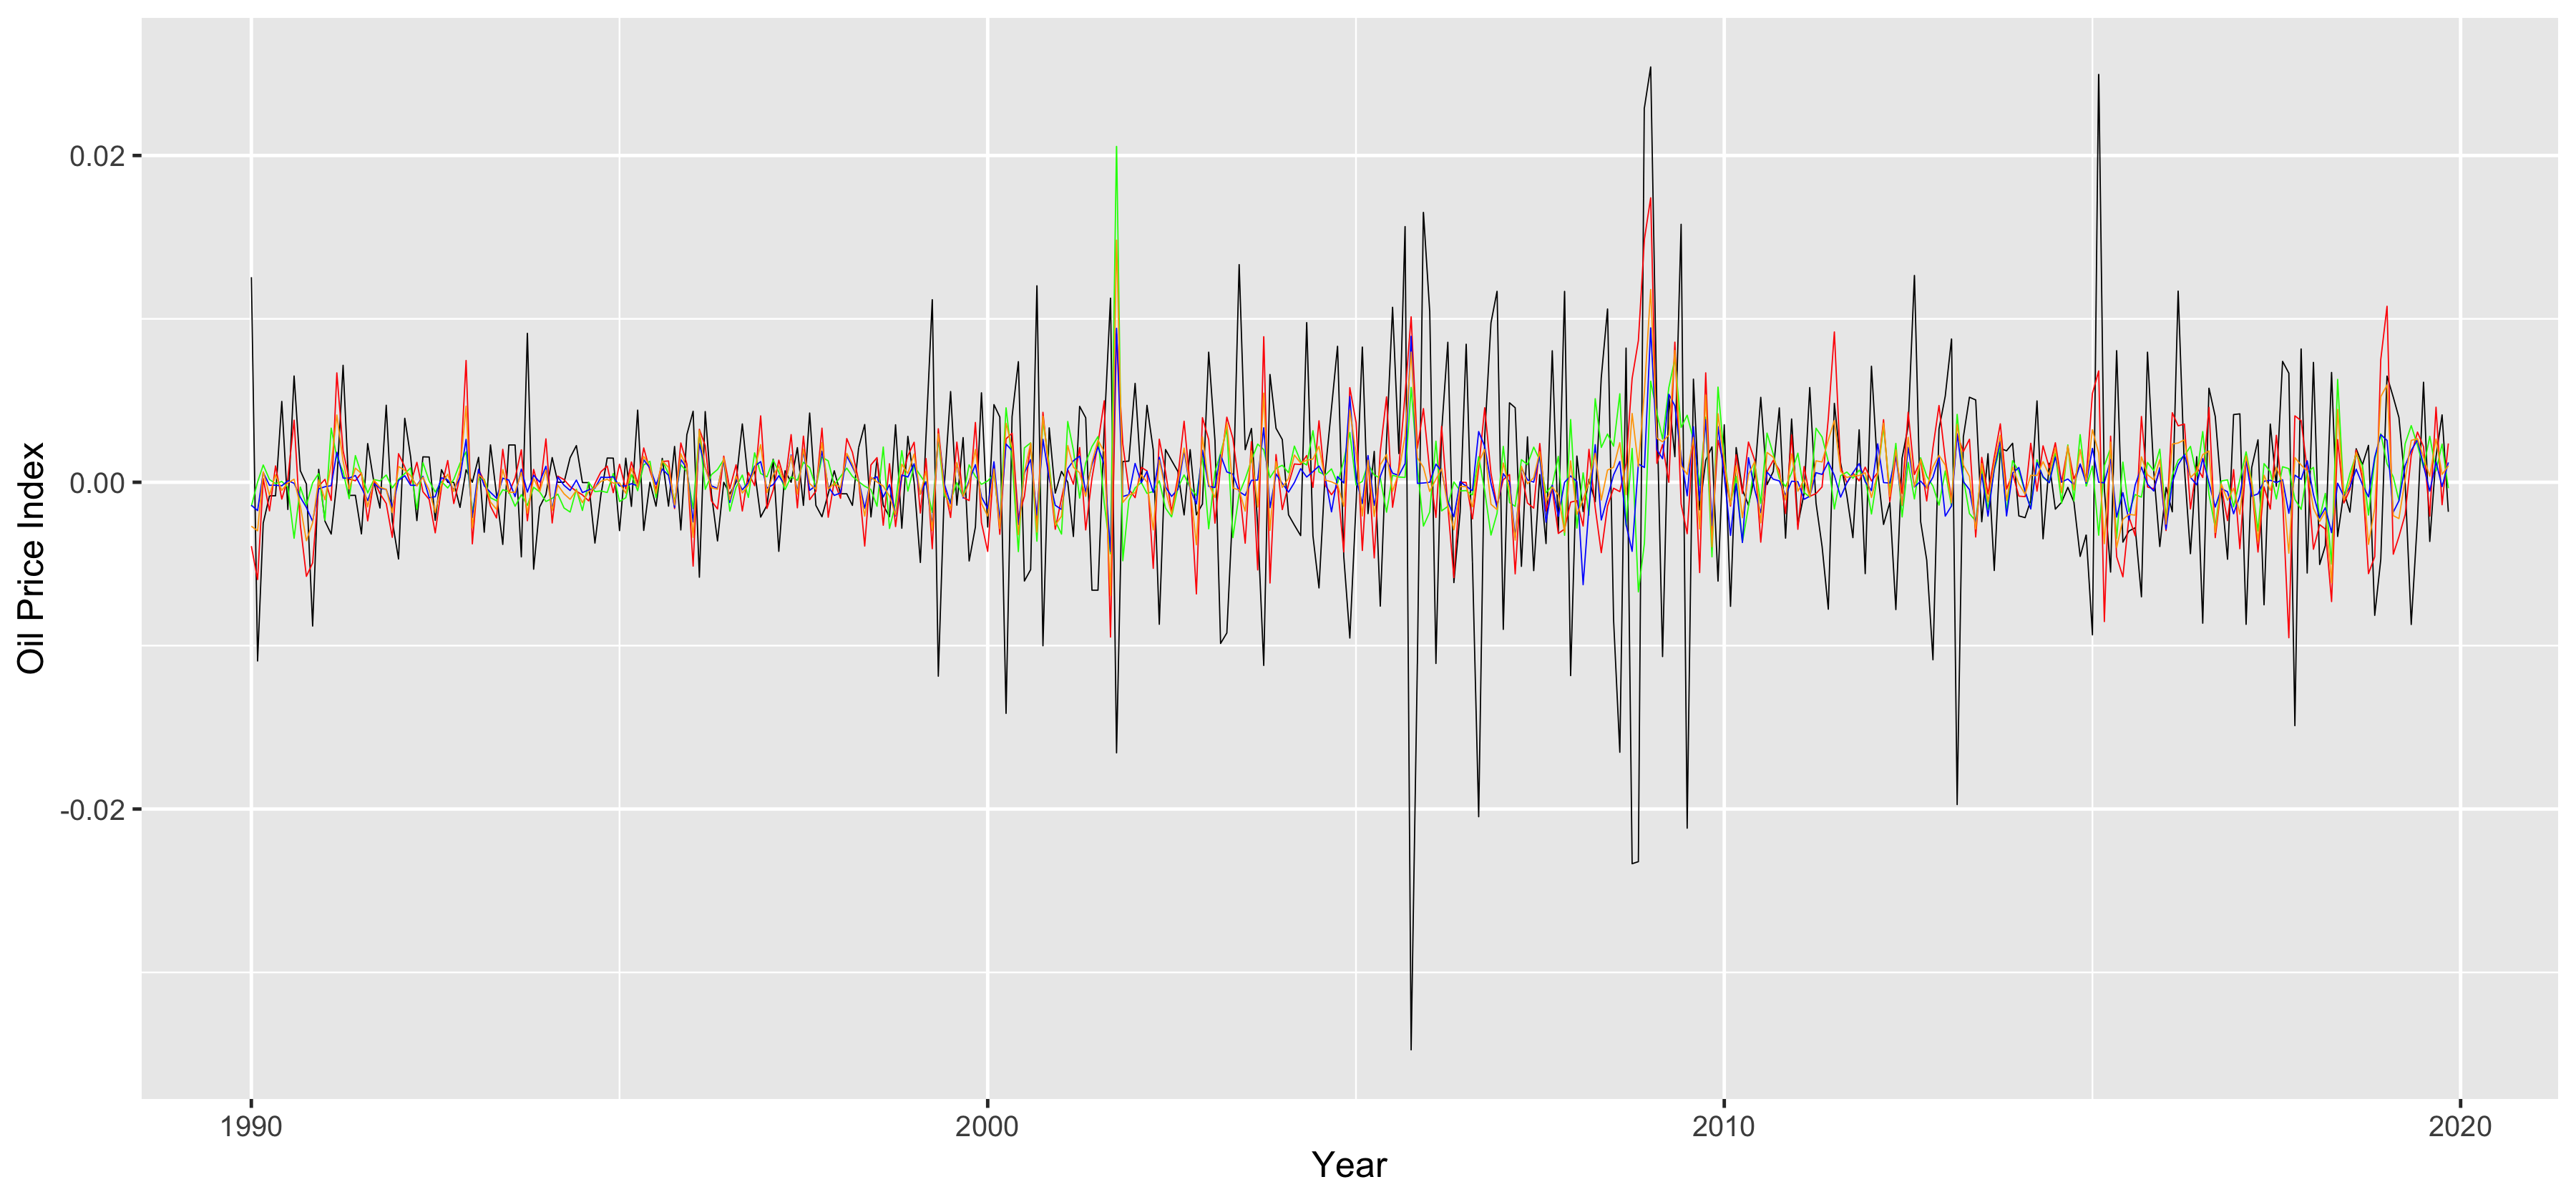

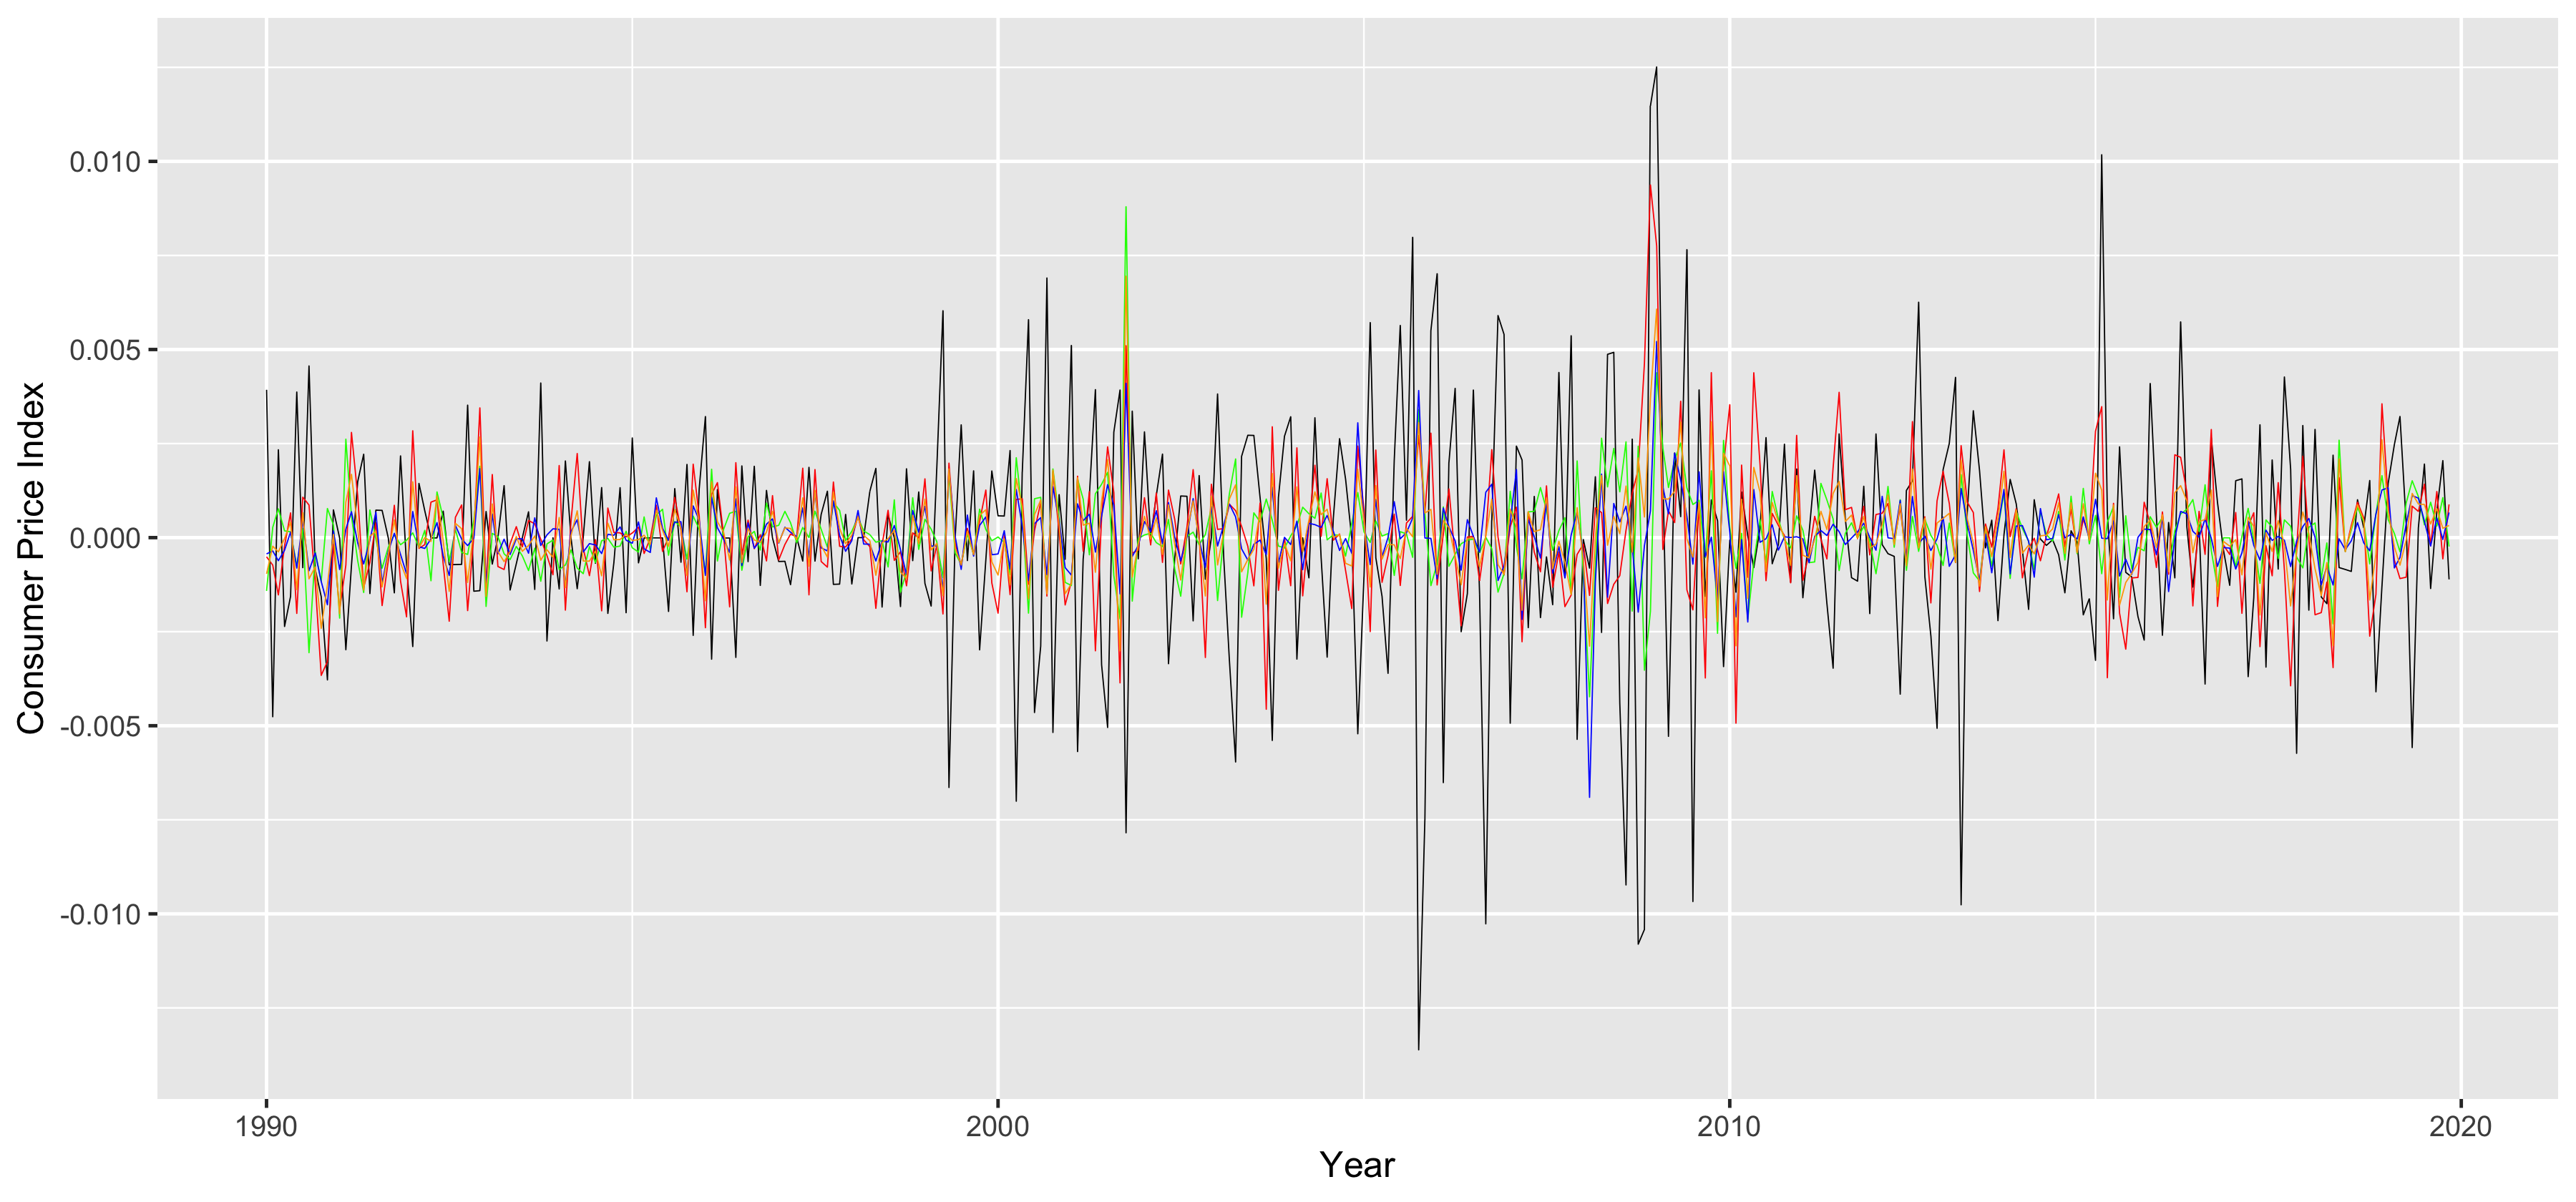

In [34]:
time_series_ISM <- dataset[(rolling_window+2):nrow(dataset),c(1, 20)]
colnames(time_series_ISM)  <- c('date', 'actual')
time_series_ISM$lasso_pred <- forecast_obj$predicted_values_ISM[,2]
time_series_ISM$pcr_pred   <- forecast_obj$predicted_values_ISM[,3]
time_series_ISM$ridge_pred <- forecast_obj$predicted_values_ISM[,4]
time_series_ISM$pcL_pred   <- forecast_obj$predicted_values_ISM[,5]

time_series_PPI <- dataset[(rolling_window+1):(nrow(dataset)-1),c(1, 106)]
colnames(time_series_PPI)  <- c('date', 'actual')
time_series_PPI$lasso_pred <- forecast_obj$predicted_values_PPI[,2]
time_series_PPI$pcr_pred   <- forecast_obj$predicted_values_PPI[,3]
time_series_PPI$ridge_pred <- forecast_obj$predicted_values_PPI[,4]
time_series_PPI$pcL_pred   <- forecast_obj$predicted_values_PPI[,5]

time_series_OIL <- dataset[(rolling_window+1):(nrow(dataset)-1),c(1, 110)]
colnames(time_series_OIL)  <- c('date', 'actual')
time_series_OIL$lasso_pred <- forecast_obj$predicted_values_OIL[,2]
time_series_OIL$pcr_pred   <- forecast_obj$predicted_values_OIL[,3]
time_series_OIL$ridge_pred <- forecast_obj$predicted_values_OIL[,4]
time_series_OIL$pcL_pred   <- forecast_obj$predicted_values_OIL[,5]

time_series_CPI <- dataset[(rolling_window+1):(nrow(dataset)-1),c(1, 113)]
colnames(time_series_CPI)  <- c('date', 'actual')
time_series_CPI$lasso_pred <- forecast_obj$predicted_values_CPI[,2]
time_series_CPI$pcr_pred   <- forecast_obj$predicted_values_CPI[,3]
time_series_CPI$ridge_pred <- forecast_obj$predicted_values_CPI[,4]
time_series_CPI$pcL_pred   <- forecast_obj$predicted_values_CPI[,5]

ggplot() + 
  geom_line(data = time_series_ISM, aes(x = date, y = actual), color = "black") +
  geom_line(data = time_series_ISM, aes(x = date, y = lasso_pred), color = "red") +
  geom_line(data = time_series_ISM, aes(x = date, y = pcr_pred), color = "green") +
  geom_line(data = time_series_ISM, aes(x = date, y = ridge_pred), color = "blue") +
  geom_line(data = time_series_ISM, aes(x = date, y = pcL_pred), color = "orange") +
  theme_grey(base_size = 30) + 
  xlab('Year') +
  ylab('ISM Manufacturing: Production Index') 
  #coord_cartesian(ylim=c(-5, 10)) 
options(repr.plot.width=30, repr.plot.height=14)

ggplot() + 
  geom_line(data = time_series_PPI, aes(x = date, y = actual), color = "black") +
  geom_line(data = time_series_PPI, aes(x = date, y = lasso_pred), color = "red") +
  geom_line(data = time_series_PPI, aes(x = date, y = pcr_pred), color = "green") +
  geom_line(data = time_series_PPI, aes(x = date, y = ridge_pred), color = "blue") +
  geom_line(data = time_series_PPI, aes(x = date, y = pcL_pred), color = "orange") +
  theme_grey(base_size = 30) + 
  xlab('Year') +
  ylab('PPI: Finished Goods') 
  #coord_cartesian(ylim=c(-5, 10)) 
options(repr.plot.width=30, repr.plot.height=14)

ggplot() + 
  geom_line(data = time_series_OIL, aes(x = date, y = actual), color = "black") +
  geom_line(data = time_series_OIL, aes(x = date, y = lasso_pred), color = "red") +
  geom_line(data = time_series_OIL, aes(x = date, y = pcr_pred), color = "green") +
  geom_line(data = time_series_OIL, aes(x = date, y = ridge_pred), color = "blue") +
  geom_line(data = time_series_OIL, aes(x = date, y = pcL_pred), color = "orange") +
  theme_grey(base_size = 30) + 
  xlab('Year') +
  ylab('Oil Price Index') 
  #coord_cartesian(ylim=c(-5, 10)) 
options(repr.plot.width=30, repr.plot.height=14)

ggplot() + 
  geom_line(data = time_series_CPI, aes(x = date, y = actual), color = "black") +
  geom_line(data = time_series_CPI, aes(x = date, y = lasso_pred), color = "red") +
  geom_line(data = time_series_CPI, aes(x = date, y = pcr_pred), color = "green") +
  geom_line(data = time_series_CPI, aes(x = date, y = ridge_pred), color = "blue") +
  geom_line(data = time_series_CPI, aes(x = date, y = pcL_pred), color = "orange") +
  theme_grey(base_size = 30) + 
  xlab('Year') +
  ylab('Consumer Price Index') 
  #coord_cartesian(ylim=c(-5, 10)) 
options(repr.plot.width=30, repr.plot.height=14)